# Prepare Circuits

In [1]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, Instruction

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.opflow import Zero, One, I, X, Y, Z

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

In [2]:
def gen_trott_gate():
    t = Parameter('t') # parameterize variable t
    
    # XX(t)
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    XX = XX_qc.to_instruction()
    
    # YY(t)
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')

    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cnot(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cnot(0,1)
    YY_qc.rx(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    YY = YY_qc.to_instruction()

        
    # ZZ(t)
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)

    # Convert custom quantum circuit into a gate
    ZZ = ZZ_qc.to_instruction()
    
    num_qubits = 3

    Trott_qr = QuantumRegister(num_qubits)
    Trott_qc = QuantumCircuit(Trott_qr, name='Trot')

    for i in range(0, num_qubits - 1):
        Trott_qc.append(ZZ, [Trott_qr[i], Trott_qr[i+1]])
        Trott_qc.append(YY, [Trott_qr[i], Trott_qr[i+1]])
        Trott_qc.append(XX, [Trott_qr[i], Trott_qr[i+1]])

    # Convert custom quantum circuit into a gate
    Trott_gate = Trott_qc.to_instruction()
    return Trott_gate

In [3]:
def gen_qcs(trott_gate: Instruction, trotter_steps: int):
    """
    Args:
        n (int): number of trotter steps
    """
    
    t = trott_gate.params[0] # assuming only t param
    
    target_time = np.pi
    
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    
    qc.x([3,5]) # prepare init state |q5q3q1> = |110>
    
    for _ in range(trotter_steps):
        qc.append(trott_gate, [qr[1], qr[3], qr[5]])
    
    qc = qc.bind_parameters({t: target_time/trotter_steps})
    
    st_qcs = fideli(qc, [qr[1], qr[3], qr[5]])
    
    return st_qcs
    
    

In [4]:
trott_steps_range = np.arange(4,15,1)
trott_gate = gen_trott_gate() # using the basic trott method (this can be changed)

qcs = {}
for trott_steps_val in trott_steps_range:
    qcs[trott_steps_val] = gen_qcs(trott_gate, trott_steps_val)

NameError: name 'fideli' is not defined

In [ ]:
qcs[10][-2].draw() # e.g. 10 trott steps, example tomo circuit

# Results

In [201]:
# load IBMQ Account data

# IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-04-11 16:26:24,991: Credentials are already in use. The existing account in the session will be replaced.


In [202]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()

In [203]:
target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
target_state = target_state.reshape(len(target_state),1)
target_state = target_state@np.conj(target_state.T)
target_state

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [9]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    return rho_fit
    # fid = state_fidelity(rho_fit, target_state)
    # return fid

In [35]:
def gen_result_single(st_qcs, backend = sim):
    shots = 8192
    reps = 8 #TODO: change back to 8

    # create jobs
    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # monitor jobs
    for job in jobs:
        job_monitor(job)
        try:
            if job.error_message() is not None:
                print(job.error_message())
        except:
            pass
    
    # calculate fids
    rhos = []
    raw_results = []
    for job in jobs:
        raw_results.append(job.result())
        rho = state_tomo(raw_results[-1], st_qcs)
        rhos.append(rho)
    
    return rhos, raw_results

def gen_results(qcs, backend = sim):
    results = {"properties": {"backend": backend}, "data":{}}
    # test = 2
    for num_trott_steps, st_qcs in tqdm(qcs.items()):
        print("="*20)
        print(f"Running with trott_steps = {num_trott_steps}")
        
        # if test <= 0:
        #     continue
        # test -= 1
        
        results["data"][num_trott_steps] = {}
        results["data"][num_trott_steps]["rhos"], results["data"][num_trott_steps]["raw_data"] = gen_result_single(st_qcs)
    return results

In [205]:
def run_analysis(results):
    results = copy.deepcopy(results)
    for num_trott_steps, result in results["data"].items():
        # calculate fids for each rep
        fids = []
        for rho in result["rhos"]:
            fids.append(state_fidelity(rho, target_state))
        fids = np.array(fids)
        result["infids"] = 1 - fids
        
        # calculate fid for avg rho
        result["avg_rho"] = np.mean(result["rhos"], axis=0)
        result["avg_infid"] =  1 - state_fidelity(result["avg_rho"], target_state)
        
        # calculate distance from |110><110| matrix element
        result["avg_element_dist"] = np.abs(target_state  - result["avg_rho"])
        
        result["avg_l1_dist"] = np.linalg.norm(target_state  - result["avg_rho"], ord=1)
        
    return results

In [198]:
def plot_metric(results, metric_func=None, plot_label="Infidelity"):
    metric_func = metric_func if metric_func is not None else lambda res: res["avg_infid"]
    steps = []
    metric = []
    for num_trott_steps, result in results["data"].items():
        steps.append(num_trott_steps)
        metric.append(metric_func(result))
    
    steps = np.array(steps)
    metric = np.array(metric)
    
    fig, axs = plt.subplots(2,2, figsize=(8,6), dpi=200)
    
    ax = axs[0][0]
    ax.plot(1/steps, metric)
    ax.set_xlabel("1/(# of Trotterization Steps)")
    ax.set_ylabel(plot_label)
    
    ax = axs[0][1]
    ax.plot(steps, metric)
    ax.set_xlabel("(# of Trotterization Steps)")
    ax.set_ylabel(plot_label)
    
    ax = axs[1][0]
    ax.plot(1/steps, np.log(metric))
    ax.set_xlabel("1/(# of Trotterization Steps)")
    ax.set_ylabel(f"log({plot_label})")
    
    ax = axs[1][1]
    ax.plot(steps, np.log(metric))
    ax.set_xlabel("(# of Trotterization Steps)")
    ax.set_ylabel(f"log({plot_label})")
    
    fig.suptitle(f"{plot_label} vs. Trotterization Step #")
    
    fig.tight_layout()
    
    return axs

def plot_fidelities(results):
    return plot_metric(results, metric_func= lambda res: res["avg_infid"], plot_label="Infidelity")

def plot_element_dist(results, row=6, col=6):
    return plot_metric(results, metric_func= lambda res: res["avg_element_dist"][row][col], plot_label=f"Element Dist. ({row}, {col})")

def plot_l1_dist(results):
    return plot_metric(results, metric_func= lambda res: res["avg_l1_dist"], plot_label=f"L1 Dist.")

## Noiseless Sims

#### Capture Data

In [15]:
results = gen_results(qcs, backend=sim)

  0%|                                                                                                                 | 0/11 [00:00<?, ?it/s]

Running with trott_steps = 4
Job ID 3cb4edf6-f672-4db3-840b-0e0e9a2ba973
Job ID 7d8be196-afbe-4e0d-b638-281f1ed3b755
Job ID e5a142be-97a1-402c-a3eb-aec324b57b93
Job ID 224b5642-7f52-4efa-9733-b610f558ddab
Job ID e552f710-9a1d-4f07-81f7-7c8308a6b1a7
Job ID 7abff62b-9180-4d09-a615-d59b3dd7f9cb
Job ID dc5e12f9-0799-4c0d-85b1-320edd0f01d8
Job ID c9fcabc7-cea3-47eb-9a69-76d7d1381a39
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


  9%|█████████▌                                                                                               | 1/11 [00:47<07:52, 47.30s/it]

Running with trott_steps = 5
Job ID 4dc69dab-3b9f-4663-9699-cd98304e3fe5
Job ID 861ff54e-1971-4cba-93e7-fa57d5383093
Job ID c459563c-c883-437f-8703-fbf8841160b1
Job ID 37ddc4dd-fc5f-4e59-8b88-16b0d5bc3457
Job ID fcd35cef-eb7f-45fa-b697-c1e8134b87ac
Job ID 5ece85c7-f64f-4bf1-b709-336107842d71
Job ID 271bbb8c-987e-4aff-9244-ddbc1b43b398
Job ID e18426e0-021c-495a-bace-6d843ba1cd69
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 18%|███████████████████                                                                                      | 2/11 [01:51<08:35, 57.28s/it]

Running with trott_steps = 6
Job ID 65242cbd-89b6-4753-a4f8-9800f539f452
Job ID 16eccaa3-81eb-4776-958c-314c980d2f5b
Job ID 2f1d1cfe-0e5f-4f5d-a3a5-ceba6fe6b90f
Job ID 4d7869c0-69fc-40da-86fe-ae97bfb5b4c2
Job ID b5d544cd-0611-414c-bcd0-39eef7fbe328
Job ID 88b9072d-f891-4b79-bb40-48d56eb2fede
Job ID f1b9e7e2-2373-4194-8516-cf1b3e5256c8
Job ID 56fe30dc-c1a9-4119-aa80-81bc63fdcb18
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 27%|████████████████████████████▋                                                                            | 3/11 [03:06<08:42, 65.25s/it]

Running with trott_steps = 7
Job ID 49f0755a-6458-4dcc-baf4-8a8c1984a64e
Job ID 2f9d98e9-6a12-472a-b192-9f05078de6af
Job ID 114cd877-8556-4146-9ac0-9d6616ffe386
Job ID 47bcefc9-9e1f-4e1b-b504-9007d4b52687
Job ID 9ab18a79-e218-469a-8137-e0c3ed31e6b2
Job ID 4887d4b4-506f-4c29-b6f5-d40f5f7e0910
Job ID 729de5e0-4605-43c4-ac81-4b77fabce262
Job ID b657c563-e3eb-4093-b263-5929d673c48d
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 36%|██████████████████████████████████████▏                                                                  | 4/11 [04:34<08:41, 74.46s/it]

Running with trott_steps = 8
Job ID 7d58d899-5f42-41a0-89b0-1d21c5232700
Job ID 87a5a558-2479-479b-8b30-6ac3aee3c0dc
Job ID 90a87b95-57cf-4320-b944-5cda3ec7f49c
Job ID 7b04342d-5796-49eb-9d1a-a3488a86eb92
Job ID c35a6def-e39b-46ca-97af-d5fa44a7436a
Job ID a02984d9-5cbb-47ed-86c1-8a5e513ce979
Job ID ea7004f8-590b-4f26-a227-c44bd382301f
Job ID 8c9e261f-42e0-4fe1-9000-d515d81f796d
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 45%|███████████████████████████████████████████████▋                                                         | 5/11 [06:16<08:25, 84.23s/it]

Running with trott_steps = 9
Job ID a065bba7-a9e5-4c2d-ba35-3efedaf001d0
Job ID 226e50d4-ed92-4b56-bd67-547a39720bc4
Job ID acb9b951-d2f2-4944-bc08-3971fb8f15ff
Job ID 02438fed-cdf0-4dee-ae2c-d62a6d9873c3
Job ID 6f5a875c-f053-4108-84d2-2d5df684d2ca
Job ID 21ef7f84-6e64-4cd7-9591-819c8e5e0db7
Job ID 795ab125-dac6-4ad5-98c4-9eade19fd9dd
Job ID d3d53701-bc98-4e08-a60e-d43731d0e631
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 55%|█████████████████████████████████████████████████████████▎                                               | 6/11 [08:18<08:05, 97.15s/it]

Running with trott_steps = 10
Job ID aea3da09-2c4f-40b8-bb35-6cb50dc247f1
Job ID 1ebd8249-42db-4bbf-91f1-6eace5b04d3f
Job ID fb314677-6fc3-405c-b980-0087462be35f
Job ID 05cdd8ff-4522-4b7c-88b1-f0250362e667
Job ID d837462f-e6cd-4b3f-a0b3-c3e20474e6e4
Job ID 1b07e037-d5ba-4c6c-9d70-c275f918afb8
Job ID 06d58c16-062e-41c4-982f-2e278b62ad7c
Job ID 6e7a028a-6fd6-4332-a0a6-b709cac995b3
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 64%|██████████████████████████████████████████████████████████████████▏                                     | 7/11 [10:21<07:02, 105.60s/it]

Running with trott_steps = 11
Job ID a0dbb2ec-c978-428e-b463-e2e311f4c58a
Job ID b2075789-54ea-4ec8-b92b-012a3e7b7d4f
Job ID 653bd9c0-ccb4-4a60-b322-b7a22301eb87
Job ID b4092a1d-6e53-4668-bb1a-10e405f8efe4
Job ID 0aa0ea4a-b308-490b-a4a2-35455f4a0370
Job ID aefa9961-4204-4965-839b-347d8ac87fd3
Job ID cfa86682-e965-4d25-92cf-12203ef31f27
Job ID 1635e3f5-5618-4da7-86ce-632f88a03c28
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 73%|███████████████████████████████████████████████████████████████████████████▋                            | 8/11 [12:40<05:48, 116.09s/it]

Running with trott_steps = 12
Job ID c514d622-862a-42f2-8711-74210bc9ca9d
Job ID 1d5adad0-21f7-43bd-97f1-1a43d600da16
Job ID 34d25c4e-0d85-4cc0-b7d2-45209ca916ad
Job ID 5c68eacb-a66f-43c3-8167-4ddf6fa46aa4
Job ID f1b3ba12-2971-4fc7-aa75-595a771e596e
Job ID 7b9c1fe7-892a-437f-be19-aafc3a0c92a5
Job ID 4265f25f-0271-4a26-885a-30f576b77543
Job ID 5f08cd17-332e-410e-b9ec-f0aa94f25ba1
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 82%|█████████████████████████████████████████████████████████████████████████████████████                   | 9/11 [15:12<04:14, 127.35s/it]

Running with trott_steps = 13
Job ID 9801ca97-7ee0-49c6-9067-f829c731245a
Job ID ba433d38-5512-48f4-89c1-cd847eea12e2
Job ID e0bd68b9-7764-4ead-aa1b-8249d6ad95c8
Job ID e41eb7f3-5103-463c-89fb-68e5c5b41836
Job ID 3ce0b32b-3718-413f-909f-d358eab4972b
Job ID 0a14afda-3821-454c-b8e8-1f906c61ea56
Job ID f4060775-519d-4945-b432-0b0a866c8e33
Job ID a5bbfb3a-2f5a-44ae-9dee-a565943efee5
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 91%|█████████████████████████████████████████████████████████████████████████████████████████████▋         | 10/11 [17:47<02:16, 136.01s/it]

Running with trott_steps = 14
Job ID a449bd75-f437-409a-a6b3-bd7ece670230
Job ID 23d730fa-e3e1-40c8-97bf-e05527202a19
Job ID 02de65a3-97f8-449a-b387-c50cc340d402
Job ID f3cb2f56-6536-47e5-be0a-2f9556414b8c
Job ID 56b5f617-5fce-4275-93a4-161082fa6457
Job ID ebc7a742-5988-406f-8fbf-0172fc91fa9c
Job ID dc9c97d9-06b4-4964-bcc2-6e4a980b4493
Job ID d821d4b4-92e9-4473-a775-03a19df4ebad
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [20:32<00:00, 112.06s/it]


#### Run Analysis

In [5]:
results["data"][10]["raw_data"][0].results[0].data.counts

NameError: name 'results' is not defined

In [206]:
res_analysis = run_analysis(results)

In [207]:
res_analysis["data"][10].keys()

dict_keys(['rhos', 'raw_data', 'infids', 'avg_rho', 'avg_infid', 'avg_element_dist', 'avg_l1_dist'])

In [209]:
res_analysis["data"][10]["infids"]

array([0.06188653, 0.06012634, 0.06063428, 0.06045267, 0.06188026,
       0.06056025, 0.06099108, 0.05935724])

In [210]:
res_analysis["data"][5]["avg_infid"], np.mean(res_analysis["data"][5]["infids"]) # these should match

(0.74316317220863, 0.7431631722086299)

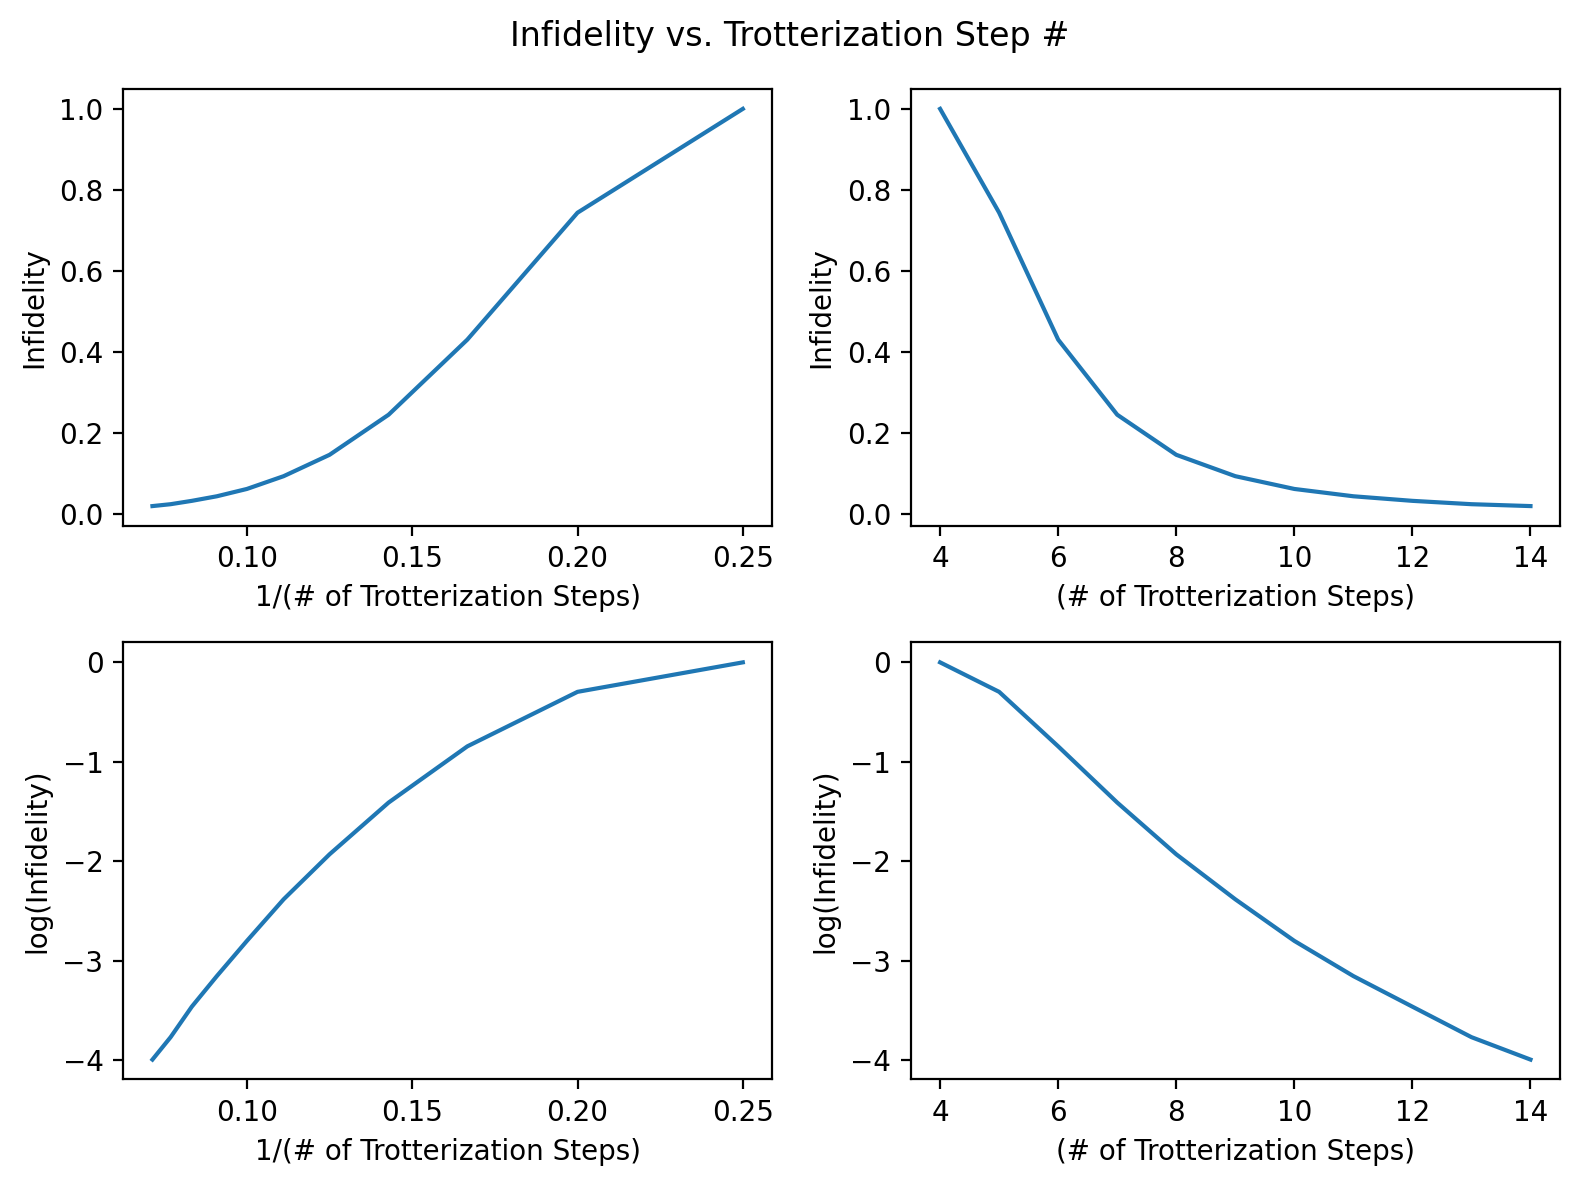

In [199]:
_ = plot_fidelities(res_analysis)

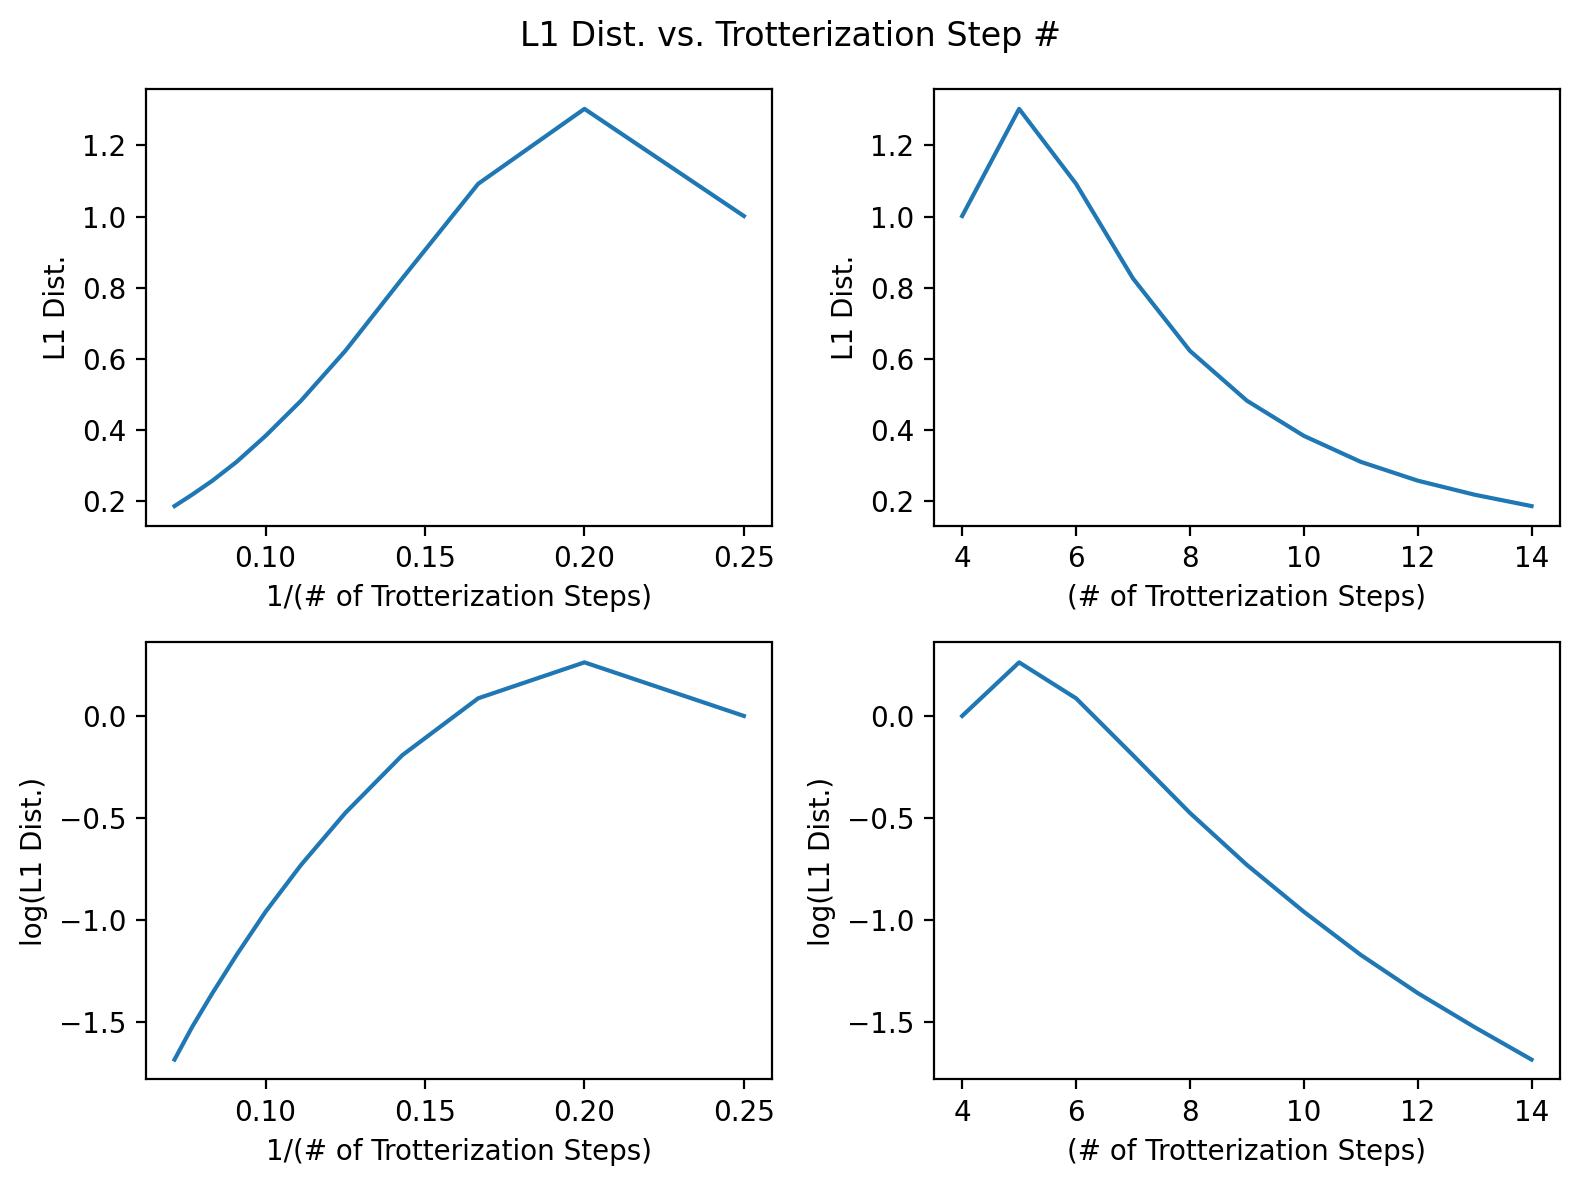

In [200]:
_ = plot_l1_dist(res_analysis)

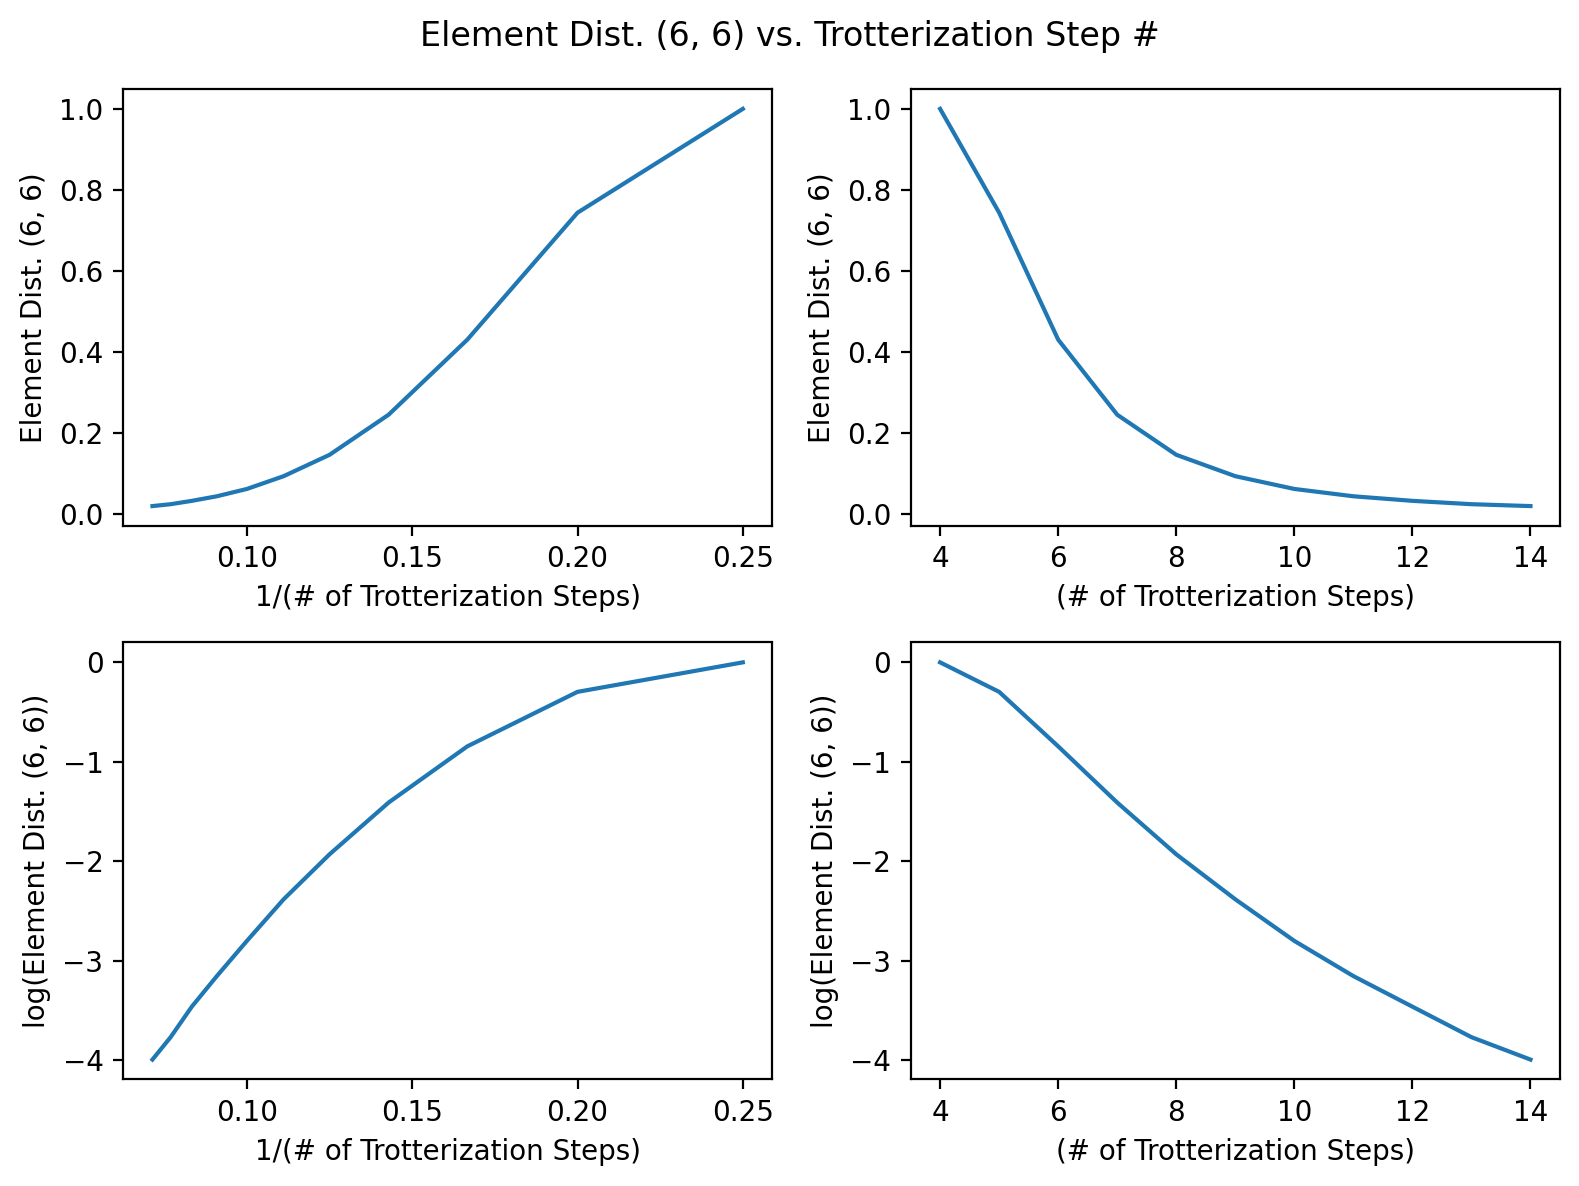

In [211]:
_ = plot_element_dist(res_analysis)

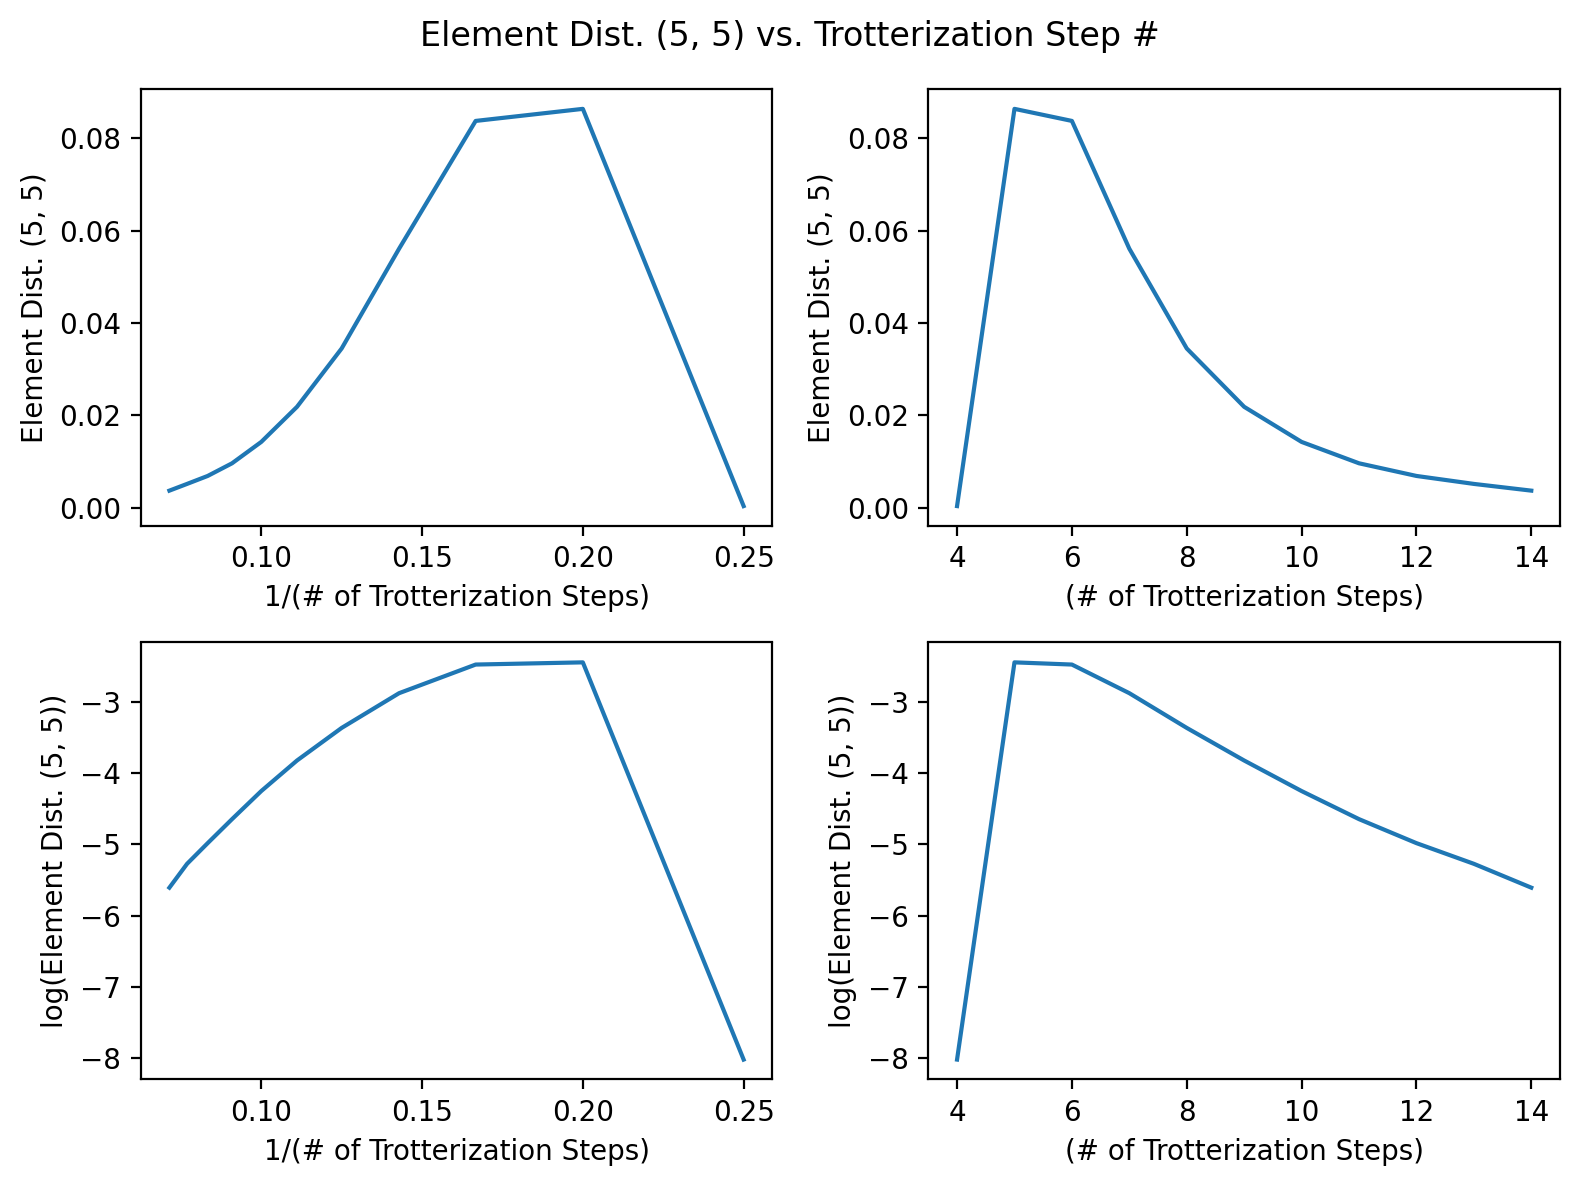

In [212]:
_ = plot_element_dist(res_analysis, row=5, col=5)

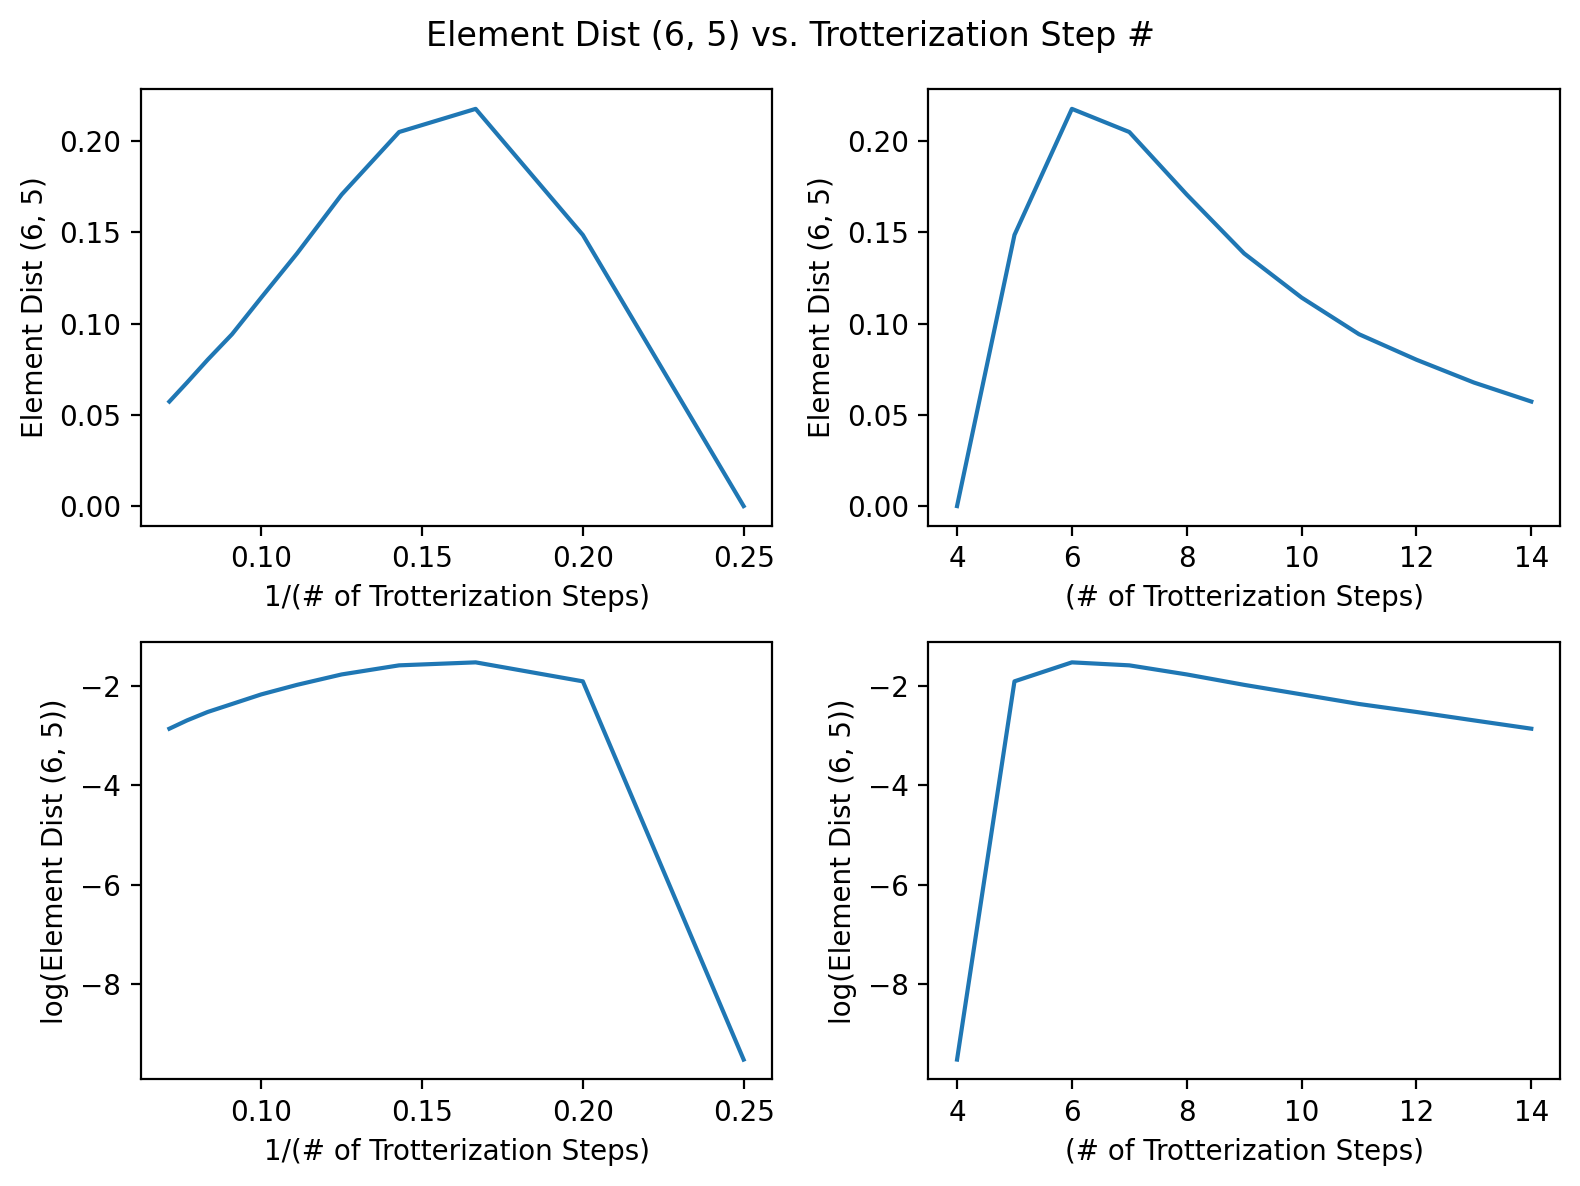

In [152]:
_ = plot_element_dist(res_analysis, row=6, col=5)

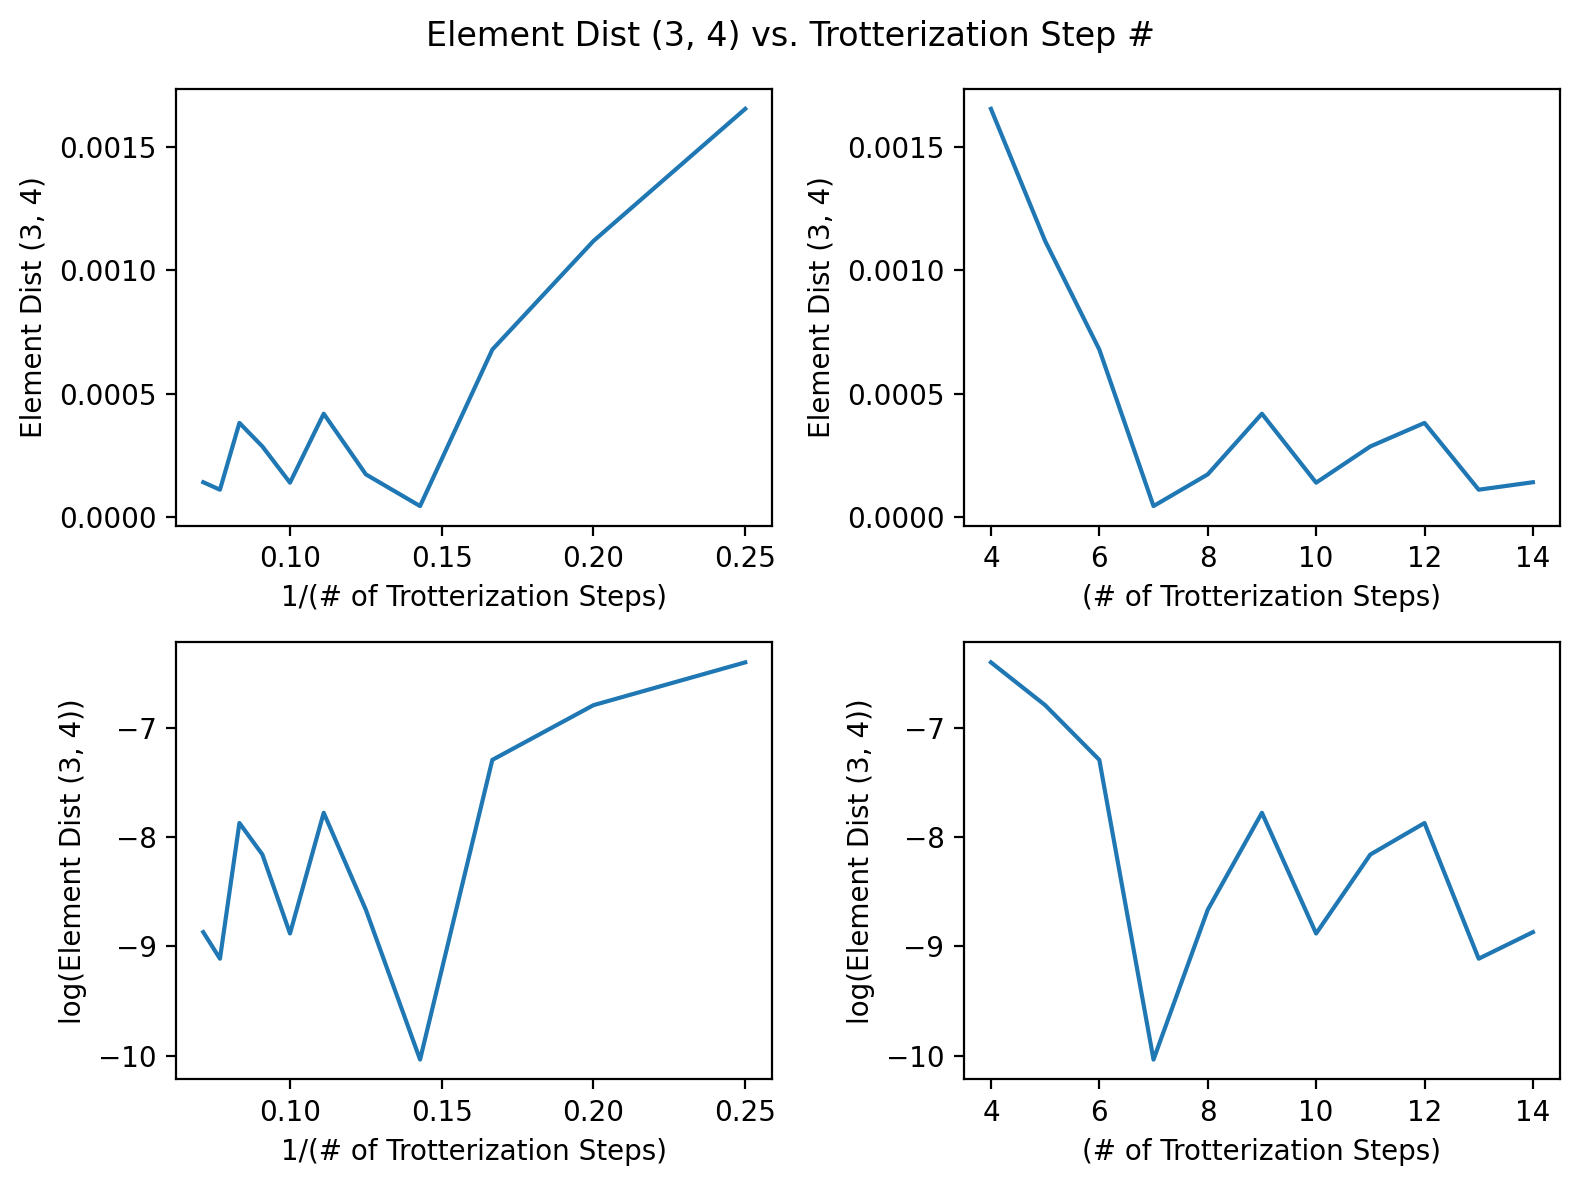

In [149]:
_ = plot_element_dist(res_analysis, row=3, col=4)